# Converting Audio into Spectrogram Images and Back

### Install dependencies

In [17]:
!pip install numpy scipy librosa pillow natsort

#### Import dependencies

In [18]:
import os
import glob
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa as rosa
import librosa.display
from PIL import Image
from natsort import natsorted

#### Set up convenience functions

In [19]:
def load_audio(path, debug=True, **kwargs):
    start = time.time()
    audio, sr = rosa.load(path, **kwargs)
    if debug:
        print(f"Loaded {audio.size / sr:.3f} seconds of audio at sr={sr} in {time.time() - start:.2f}s")
        show_audio(audio, rate=sr)
    return audio, sr

def show_audio(audio, **kwargs):
    start = time.time()
    ipd.display(ipd.Audio(audio, **kwargs))
    
def show_spec(spec, sr, y_axis='log', scale_fn=rosa.amplitude_to_db, title=None, **kwargs):
    log_spec = scale_fn(spec, ref=np.max)
    plt.figure(figsize=(12, 4))
    rosa.display.specshow(log_spec, sr=sr, x_axis="time", y_axis='log', **kwargs)
    plt.colorbar(format='%+2.0f dB')
    if title:
        plt.title(title)

def stft(audio, debug=True, **kwargs):
    start = time.time()
    stft = rosa.stft(audio, **kwargs)
    if debug:
        print(f"STFT'd {audio.size} samples of audio in {time.time() - start:.2f}s")
    return stft

def griffinlim(spec, debug=True, **kwargs):
    start = time.time()
    recon = rosa.griffinlim(spec, **kwargs)
    if debug:
        print(f"Reconstructed {recon.size} samples in {time.time() - start:.2f} seconds")
    return recon

def chunkify(spec, pixels_per_chunk=128, truncate=True, debug=True, **kwargs):
    start = time.time()
    remainder = spec.shape[1] % pixels_per_chunk
    if truncate:
        last_index = spec.shape[1] - remainder
        spec_chunkable = spec[..., :last_index]
    else:
        spec_chunkable = np.pad(spec, ((0, 0), (0, pixels_per_chunk - remainder)), mode='constant')
    if debug:
        if truncate:
            print(f"Truncated spectrogram shape: {spec_chunkable.shape}")
        else:
            print(f"Padded spectrogram shape: {spec_chunkable.shape}")
    chunks = np.split(spec_chunkable, spec_chunkable.shape[1] // pixels_per_chunk, axis=1)
    if debug:
        print(f"Split ({spec.shape[1]} x {spec.shape[0]}) image into {len(chunks)} chunks in {time.time() - start:.2f} seconds")
    return chunks

def save_chunks(chunks, output_dir, basename=None):
    output_dir = os.path.realpath(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    if basename is None:
        basename = os.path.basename(output_dir)
    for i, chunk in enumerate(chunks):
        img = Image.fromarray(chunk[::-1], mode='F')
        img.save(os.path.join(output_dir, f"{basename}_{i}.tiff"))
              
def load_chunks(chunks_dir, name_format='*_*.tiff', reconstruct=False,
                concatenate=False, debug=True, **kwargs):
    start = time.time()
    files = natsorted(glob.glob(os.path.join(chunks_dir, name_format)))
    chunks = [np.asarray(Image.open(file))[::-1] for file in files]
    if reconstruct:
        recon = [griffinlim(chunk, debug=False) for chunk in chunks]
        if concatenate:
            recon = np.concatenate(recon)
        if debug:
            print(f"Loaded and reconstructed {len(files)} chunks in {time.time() - start:.2f}s")
        return recon
    else:
        if concatenate:
            chunks = np.concatenate(chunks, axis=-1)
        if debug:
            print(f"Loaded {len(files)} chunks in {time.time() - start:.2f}s")
        return chunks

#### Global constants - change as needed

In [20]:
AUDIO_PATH = "../data/fma/audio/000002.mp3"
# AUDIO_PATH = "../data/audio/edm/Vicetone - Heat (Original Mix) HQ.mp3"
START = 0
DURATION = 4

#### Reconstruction parameters - maybe don't fiddle with these

In [21]:
SAMPLE_RATE = 32768
FFT = 2048
HOP = FFT // 4
ITER = 32

In [22]:
# Load audio
audio, sr = load_audio(AUDIO_PATH, sr=SAMPLE_RATE, offset=START, duration=DURATION, res_type='kaiser_best')

/home/krishna/anaconda3/envs/ai/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Loaded 4.000 seconds of audio at sr=32768 in 0.23s


(256, 513)


/home/krishna/anaconda3/envs/ai/lib/python3.7/site-packages/librosa/filters.py:222: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


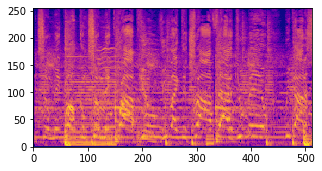

In [23]:
mel = rosa.feature.melspectrogram(audio, sr=sr, n_mels=256, n_fft=1024, hop_length=256)
print(mel.shape)
plt.figure(figsize=(5, 5))
plt.imshow(rosa.power_to_db(mel, ref=np.max), origin='lower', cmap='plasma')
plt.show()

N_FFT: 4096 | HOP_LENGTH: 256 | N_MELS: 512
Spectrogram shape: (512, 513)


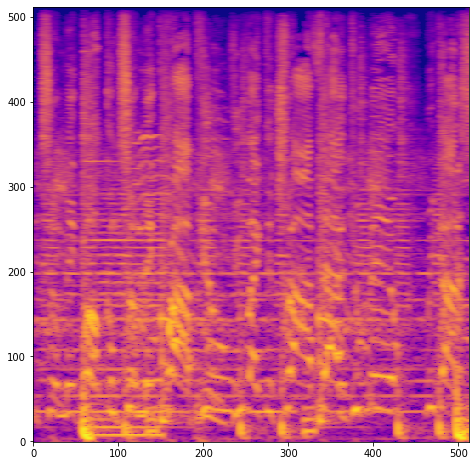

Reconstred 130816 samples (3.9921875)s in 64.43s


In [24]:
configs = [
    {'n_mels': 512, 'n_fft': 4096, 'hop_length': 256},
#     {'n_mels': 512, 'n_fft': 1024, 'hop_length': 256},
#     {'n_mels': 512, 'n_fft': 2048, 'hop_length': 128},
#     {'n_mels': 512, 'n_fft': 2048, 'hop_length': 256},
#     {'n_mels': 512, 'n_fft': 2048, 'hop_length': 512},
#     {'n_mels': 512, 'n_fft': 4096, 'hop_length': 128},
#     {'n_mels': 512, 'n_fft': 4096, 'hop_length': 512},
#     {'n_mels': 256, 'n_fft': 4096, 'hop_length': 1024},
#     {'n_mels': 512, 'n_fft': 4096, 'hop_length': 1024},
]

for config in configs:
    n_fft = config['n_fft']
    hop_length = config['hop_length']
    n_mels = config['n_mels']
    print(f"N_FFT: {n_fft} | HOP_LENGTH: {hop_length} | N_MELS: {n_mels}")
    spec = rosa.feature.melspectrogram(audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    print(f"Spectrogram shape: {spec.shape}")
    plt.figure(figsize=(8, 8))
    plt.imshow(rosa.power_to_db(spec, ref=np.max), origin='lower', cmap='plasma')
    plt.show()
    start = time.time()
    recon = rosa.feature.inverse.mel_to_audio(spec[:, :-1], sr=sr, n_fft=n_fft, hop_length=hop_length)
    print(f"Reconstred {len(recon)} samples ({len(recon) / sr})s in {time.time() - start:.2f}s")
    show_audio(recon, rate=sr)
    print("=================================================================================")

STFT'd 131072 samples of audio in 0.00s
Spectrogram dimensions: (1025, 257)
64.2500 pixels per second
1025 frequency bins


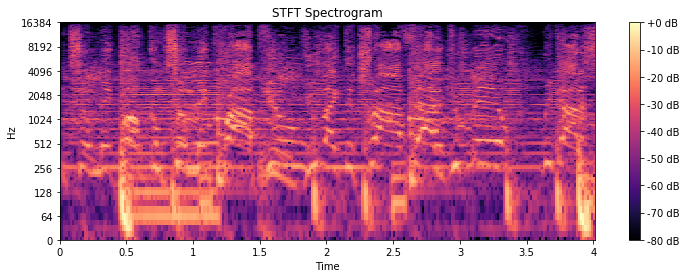

In [25]:
spec = np.abs(stft(audio, n_fft=FFT, hop_length=HOP))
spec = spec / spec.max()
print(f"Spectrogram dimensions: {spec.shape}")
print(f"{spec.shape[1] / (audio.size / sr):.4f} pixels per second")
print(f"{spec.shape[0]} frequency bins")
show_spec(spec, sr, title="STFT Spectrogram")

#### Level 1: Convert Audio to STFT and back

In [26]:
recon = griffinlim(spec, n_iter=ITER, win_length=FFT, hop_length=HOP)
show_audio(recon, rate=sr)

Reconstructed 131072 samples in 0.36 seconds


#### Level 2: Convert Audio to Image and back

In [27]:
from PIL import Image

img = Image.fromarray(spec[::-1], mode='F')
img.save('stft.tiff')
recon_spec = np.asarray(Image.open('stft.tiff'))[::-1]
recon = griffinlim(recon_spec, n_iter=ITER, hop_length=HOP)

show_audio(recon, rate=sr)

Reconstructed 131072 samples in 0.31 seconds


#### Level 3: Convert Audio into chunk-sized Images and back

In [28]:
PIXELS_PER_CHUNK = 512
TRUNCATE = False  # Whether to truncate or zero-pad the spectrogram before chunking

In [29]:
chunks = chunkify(spec, truncate=TRUNCATE, pixels_per_chunk=PIXELS_PER_CHUNK)
save_chunks(chunks, 'stft')
recon = load_chunks('stft', reconstruct=True, concatenate=True)

Padded spectrogram shape: (1025, 512)
Split (257 x 1025) image into 1 chunks in 0.00 seconds
Loaded and reconstructed 1 chunks in 0.56s


STFT'd 261632 samples of audio in 0.00s


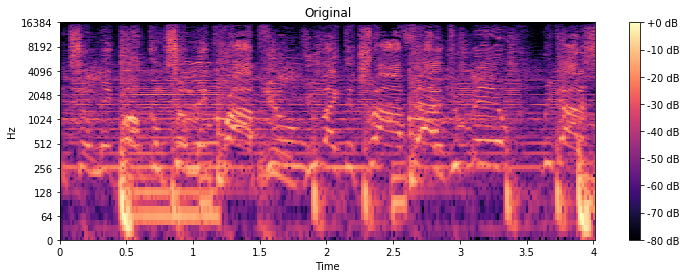

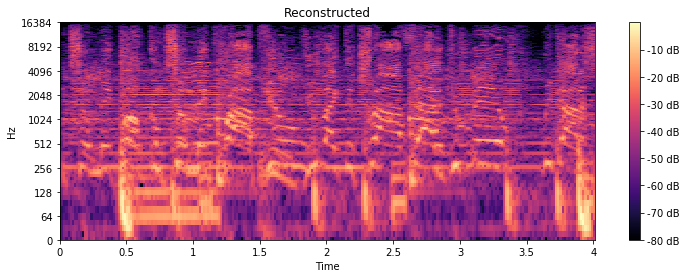

In [30]:
show_audio(recon, rate=sr)
final_spec = np.abs(stft(recon, n_fft=FFT, hop_length=HOP))
shortest = min(spec.shape[1], final_spec.shape[1])
show_spec(spec[..., :shortest], sr, title="Original")
show_spec(final_spec[..., :shortest], sr, title="Reconstructed")